In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore")

# Определение опасного сайта по URL

Данные взяты из <a href='https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs'>репозитория</a> на Github. Автор собирал адреса из открытых списков опасных и безопасных сайтов.

## Описание набора данных

Набор данных состоит из двух столбцов:<br/><br/>
'<b>url</b>' - строка с адресом сайта (не содержит названия протокола)<br/>
'<b>label</b>' - значение целевой переменной, содержит метки 'good' и 'bad', определяющие безопасен сайт или нет.<br/><br/>
Будем решать задачу бинарной классификации.

In [3]:
df = pd.read_csv('data.csv')
df.head(5)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     420464 non-null  object
 1   label   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


Всего в датасете 420464 строки и отсутствуют пропущенные значения

Проверим, есть ли в датасете дубликаты 

In [5]:
df.shape[0] - df.drop_duplicates().shape[0]

9216

В датасете 9216 дубликатов. Удалим их.

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.reset_index(drop=True)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
...,...,...
411243,23.227.196.215/,bad
411244,apple-checker.org/,bad
411245,apple-iclods.org/,bad
411246,apple-uptoday.org/,bad


Заменим bad на 0, good на 1 в столбце целевого признака.

In [8]:
df['label'] = df['label'].map({'bad': 0, 'good': 1})

In [17]:
X = df.drop(['label'], axis=1)
y = df[['label']]
print(f'Признаков класса 0: {np.sum(y.to_numpy() == 0)}\nПризнаков класса 1: {np.sum(y.to_numpy() == 1)}')
if np.sum(y.to_numpy()==0) > np.sum(y.to_numpy()==1):
    print(f'Признаков класса 0 в {np.sum(y.to_numpy()==0)/np.sum(y.to_numpy()==1):.2f} раз больше')
else:
    print(f'Признаков класса 1 в {np.sum(y.to_numpy()==1)/np.sum(y.to_numpy()==0):.2f} раз больше')   

Признаков класса 0: 66448
Признаков класса 1: 344800
Признаков класса 1 в 5.19 раз больше


In [18]:
type(y)

pandas.core.frame.DataFrame

Видна явная несбалансированость классов. Позже, можно будет использовать методы для борьбы с ней. Пока разделим наш датасет на обучающий и тестовый набор данных.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True, stratify=y)

In [21]:
y_train

,label
1054,0
198838,1
81669,1
14079,0
127090,1
...,...
21839,0
223373,1
289262,1
334791,1


### Проведем EDA.

У нас только один признак - url. Попробуем выделить из него дополнительные признаки.</br>
Предположения:
1) Возможно длина адреса влияет на целевую переменную. Предположим, что длинные ссылки чаще явлются вредоносными.
2) Количество цифр в адресе тоже может влиять на подозрительность ссылки. Чем больше цифр, тем менее понятно, куда перенаправляет нас ссылка.
3) Если вместо адреса используется IP, то есть вероятность, что это вредоносная ссылка
4) Будем проверять содержить ли url запрос 
5) Проверка на наличие '@'. Браузер игнорирует все, что находится перед данным символом.
6) Наличие в домене букв в верхнем регистре

In [22]:
from urllib.parse import urlparse

In [23]:
urlparse(X_train['url'].iloc[2])

ParseResult(scheme='', netloc='', path='en.wikipedia.org/wiki/Louis-Hector_de_Calli%C3%A8re', params='', query='', fragment='')

In [24]:
X_train

,url
1054,edf.fr.kfskz.com/facture_edf.pdf.03.exe
198838,bradmays.com/watermeloncast.html
81669,en.wikipedia.org/wiki/Louis-Hector_de_Calli%C3...
14079,66.90.121.114/ip-7/encoded/Oi8vd3d3LmJhbnJ1cmF...
127090,obituaries.bangordailynews.com/obituaries/bang...
...,...
21839,ly-can.com/main/img/css/loginAlibaba.php?useri...
223373,economicexpert.com/a/Paul:Gottlieb:Nipkow.htm
289262,marriott.com/hotels/travel/mcipl-kansas-city-m...
334791,shreyaghoshal.com/


Так как urllib не выводит отдельно домен, то воспользуемся также библиотекой <a href='https://pypi.org/project/tldextract/'>tldextract</a>

In [25]:
!pip install tldextract

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import tldextract
import ipaddress as ip

In [14]:
tldextract.extract(X_train['url'].iloc[2])

ExtractResult(subdomain='en', domain='wikipedia', suffix='org')

Также используется библиотека ipaddress, где есть метод ip_address, который вернет ошибку, если будет подан не ip-адрес

In [27]:
def check_ip(domain):
    try:
        if ip.ip_address(domain):
            return 1
    except:
        return 0

In [28]:
df_1 = df.copy()

In [29]:
df_1['url_len'] = df_1['url'].apply(len) # Вводим столбец с длиной адреса

In [30]:
df_1

,url,label,url_len
0,diaryofagameaddict.com,0,22
1,espdesign.com.au,0,16
2,iamagameaddict.com,0,18
3,kalantzis.net,0,13
4,slightlyoffcenter.net,0,21
...,...,...,...
420459,23.227.196.215/,0,15
420460,apple-checker.org/,0,18
420461,apple-iclods.org/,0,17
420462,apple-uptoday.org/,0,18


In [31]:
import re

In [32]:
df_1['tfldextract'] = df_1['url'].apply(tldextract.extract)
df_1['num_digits_dom'] = df_1['tfldextract'].apply(lambda x: len(re.findall('(\d+)', x.domain)))

In [33]:
df_1

,url,label,url_len,tfldextract,num_digits_dom
0,diaryofagameaddict.com,0,22,"(, diaryofagameaddict, com)",0
1,espdesign.com.au,0,16,"(, espdesign, com.au)",0
2,iamagameaddict.com,0,18,"(, iamagameaddict, com)",0
3,kalantzis.net,0,13,"(, kalantzis, net)",0
4,slightlyoffcenter.net,0,21,"(, slightlyoffcenter, net)",0
...,...,...,...,...,...
420459,23.227.196.215/,0,15,"(, 23.227.196.215, )",4
420460,apple-checker.org/,0,18,"(, apple-checker, org)",0
420461,apple-iclods.org/,0,17,"(, apple-iclods, org)",0
420462,apple-uptoday.org/,0,18,"(, apple-uptoday, org)",0


In [34]:
df_1['num_@'] = df_1['url'].apply(lambda x: x.count('@'))
df_1['num_slash'] = df_1['url'].apply(lambda x: x.count('/'))

In [35]:
df_1

,url,label,url_len,tfldextract,num_digits_dom,num_@,num_slash
0,diaryofagameaddict.com,0,22,"(, diaryofagameaddict, com)",0,0,0
1,espdesign.com.au,0,16,"(, espdesign, com.au)",0,0,0
2,iamagameaddict.com,0,18,"(, iamagameaddict, com)",0,0,0
3,kalantzis.net,0,13,"(, kalantzis, net)",0,0,0
4,slightlyoffcenter.net,0,21,"(, slightlyoffcenter, net)",0,0,0
...,...,...,...,...,...,...,...
420459,23.227.196.215/,0,15,"(, 23.227.196.215, )",4,0,1
420460,apple-checker.org/,0,18,"(, apple-checker, org)",0,0,1
420461,apple-iclods.org/,0,17,"(, apple-iclods, org)",0,0,1
420462,apple-uptoday.org/,0,18,"(, apple-uptoday, org)",0,0,1


In [36]:
df_1['query'] = df_1['url'].apply(urlparse).apply(lambda x: 0 if x.query == '' else 1)

In [37]:
df_1

,url,label,url_len,tfldextract,num_digits_dom,num_@,num_slash,query
0,diaryofagameaddict.com,0,22,"(, diaryofagameaddict, com)",0,0,0,0
1,espdesign.com.au,0,16,"(, espdesign, com.au)",0,0,0,0
2,iamagameaddict.com,0,18,"(, iamagameaddict, com)",0,0,0,0
3,kalantzis.net,0,13,"(, kalantzis, net)",0,0,0,0
4,slightlyoffcenter.net,0,21,"(, slightlyoffcenter, net)",0,0,0,0
...,...,...,...,...,...,...,...,...
420459,23.227.196.215/,0,15,"(, 23.227.196.215, )",4,0,1,0
420460,apple-checker.org/,0,18,"(, apple-checker, org)",0,0,1,0
420461,apple-iclods.org/,0,17,"(, apple-iclods, org)",0,0,1,0
420462,apple-uptoday.org/,0,18,"(, apple-uptoday, org)",0,0,1,0


In [38]:
df_1['caps'] = df_1['tfldextract'].apply(lambda x: 1 if len(re.compile('[A-Z]+').findall(x.domain)) > 0 else 0)

In [39]:
df_1['domain_ip'] = df_1['tfldextract'].apply(lambda x: check_ip(x.domain))

In [40]:
df_1.head(5)

,url,label,url_len,tfldextract,num_digits_dom,num_@,num_slash,query,caps,domain_ip
0,diaryofagameaddict.com,0,22,"(, diaryofagameaddict, com)",0,0,0,0,0,0
1,espdesign.com.au,0,16,"(, espdesign, com.au)",0,0,0,0,0,0
2,iamagameaddict.com,0,18,"(, iamagameaddict, com)",0,0,0,0,0,0
3,kalantzis.net,0,13,"(, kalantzis, net)",0,0,0,0,0,0
4,slightlyoffcenter.net,0,21,"(, slightlyoffcenter, net)",0,0,0,0,0,0


In [45]:
df_1.groupby('domain_ip')['url'].nunique()

domain_ip
0    407565
1      3682
Name: url, dtype: int64

### Посмотрим визуализацию зависимостей полученных признаков

In [47]:
from pylab import rcParams

rcParams["figure.figsize"] = 10, 5

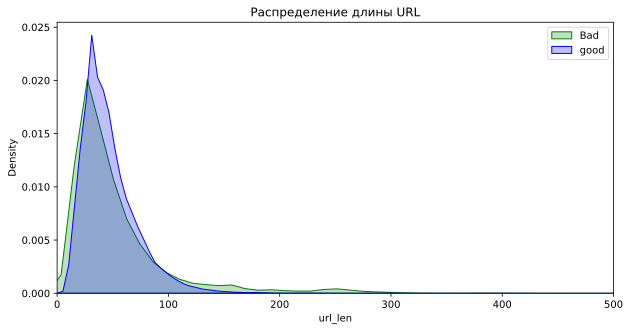

In [48]:
sns.kdeplot(df_1[df_1['label'] == 0]['url_len'], color='g', shade=True, label='Bad')
sns.kdeplot(df_1[df_1['label'] == 1]['url_len'], color='b', shade=True, label='good')
plt.title(f'Распределение длины URL')
plt.xlim(0, 500)
plt.legend()
plt.savefig('1.png')
plt.show()

In [49]:
print('Количество плохих адресов с длиной больше 500 символов', end=': ')
print(df_1['url'][(df_1['url_len'] > 500) & (df_1['label'] == 0)].count())

Количество плохих адресов с длиной больше 500 символов: 263


In [29]:
print('Количество хороших адресов с длиной больше 500 символов', end=': ')
print(df_1['url'][(df_1['url_len'] > 500) & (df_1['label'] == 1)].count())

Количество хороших адресов с длиной больше 500 символов: 8


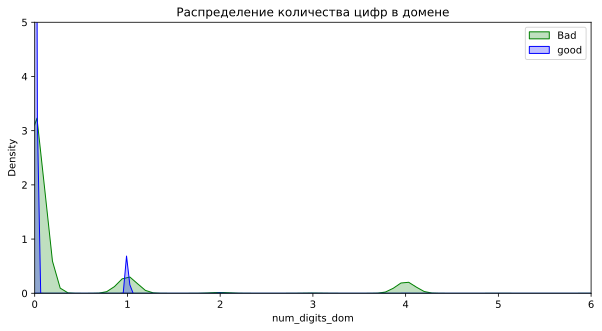

In [50]:
sns.kdeplot(df_1[df_1['label'] == 0]['num_digits_dom'], color='g', shade=True, label='Bad')
sns.kdeplot(df_1[df_1['label'] == 1]['num_digits_dom'], color='b', shade=True, label='good')
plt.title('Распределение количества цифр в домене')
plt.xlim(0, 6)
plt.ylim(0, 5)
plt.legend()
plt.savefig('2.png')
plt.show()

In [51]:
tmp1 = sum(df_1[df_1['label'] == 0]['num_digits_dom'] > 1)
print(f'Количество вредоносных сайтов с количеством цифр в домене > 1: {tmp1}')

tmp2 = sum(df_1[df_1['label'] == 1]['num_digits_dom'] > 1)
print(f'Количество безопасных сайтов с количеством цифр в домене > 1: {tmp2}')

Количество вредоносных сайтов с количеством цифр в домене > 1: 4028
Количество безопасных сайтов с количеством цифр в домене > 1: 131


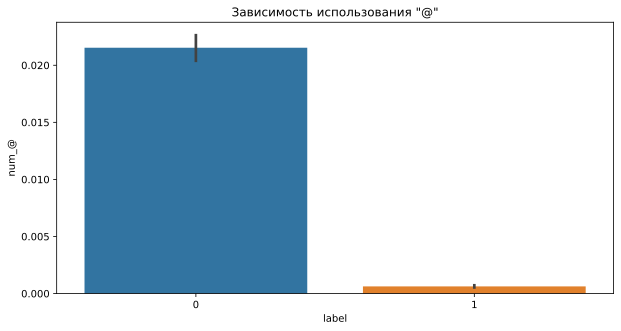

In [52]:
sns.barplot(x='label', y='num_@', data=df_1)
plt.title('Зависимость использования "@"')
plt.savefig('3.png')
plt.show()

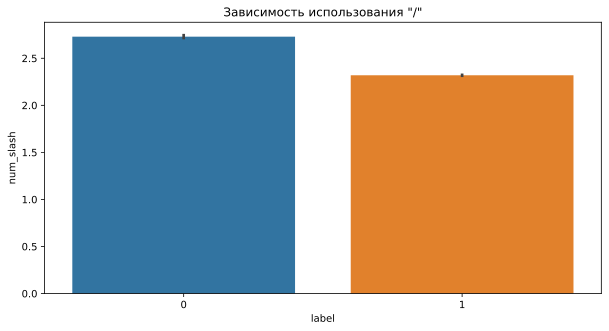

In [53]:
sns.barplot(x='label', y='num_slash', data=df_1)
plt.title('Зависимость использования "/"')
plt.savefig('4.png')
plt.show()

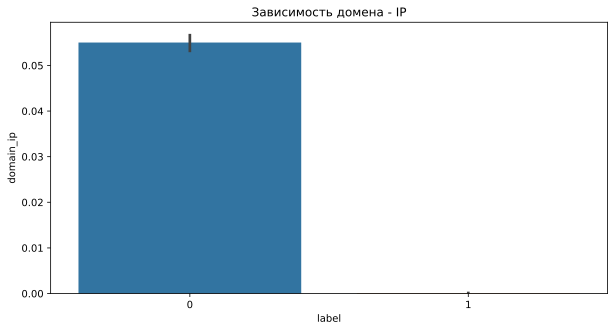

In [54]:
sns.barplot(x='label', y='domain_ip', data=df_1)
plt.title('Зависимость домена - IP')
plt.savefig('5.png')
plt.show()

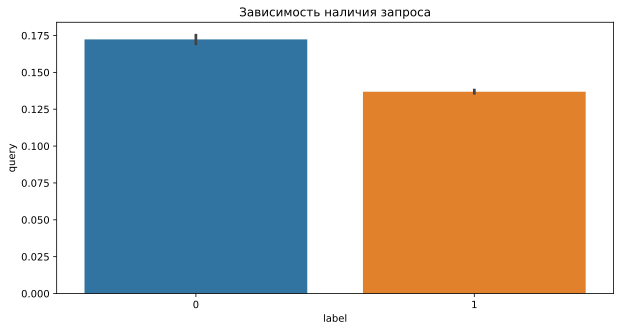

In [55]:
sns.barplot(x='label', y='query', data=df_1)
plt.title('Зависимость наличия запроса')
plt.savefig('6.png')
plt.show()

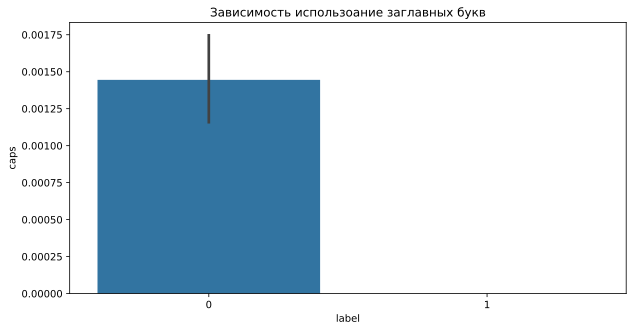

In [56]:
sns.barplot(x='label', y='caps', data=df_1)
plt.title('Зависимость использоание заглавных букв')
plt.savefig('7.png')
plt.show()

По полученным графикам видно, что сайты с длинным url вероятнее окажутся вредоносными, чем сайты с более коротким url, но все равно зависимость слишком слабая.</br>
Но зато можно утверждать, что наличие верхнего регистра, IP вместо домена и наличие символа @ указывает на вредоносность сайта, как и предполагалось, но в общем объектов</br>
с такими признаками небольшое количество.

### Метрики

Будем использовать ROC-AUC и recall для нулевого класса, так как важно находить как можно большее количество вредоносных сайтов. Также будем выводить confusion matrix.

### Выбор и обучение модели

Так как url являются текстовыми данными, то логичнее также преобразовать их, использовав tfidf.

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import *

Для начала зададим рандомные параметры

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df['url'], df['label'], 
                                                      test_size=0.3, random_state=17, stratify=df['label'])

In [59]:
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=50000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [40]:
X_train_tfidf

<287873x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 1569845 stored elements in Compressed Sparse Row format>

Попробуем обучить логистическую регрессию с параметрами по умолчанию

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

In [43]:
X_train_tfidf.shape

(287873, 50000)

In [63]:
log_reg = LogisticRegression(tol=0.01)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(tol=0.01)

In [45]:
roc_auc_score(y_test, log_reg.predict_proba(X_test_tfidf)[:, 1])

0.9852193256394414

In [46]:
roc_auc_score(y_test, log_reg.predict(X_test_tfidf))

0.9073821124429151

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, log_reg.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89     19934
           1       0.97      0.99      0.98    103441

    accuracy                           0.97    123375
   macro avg       0.96      0.91      0.93    123375
weighted avg       0.97      0.97      0.96    123375



In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    sns.set_style('dark')
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 16366   3568]
 [   646 102795]]


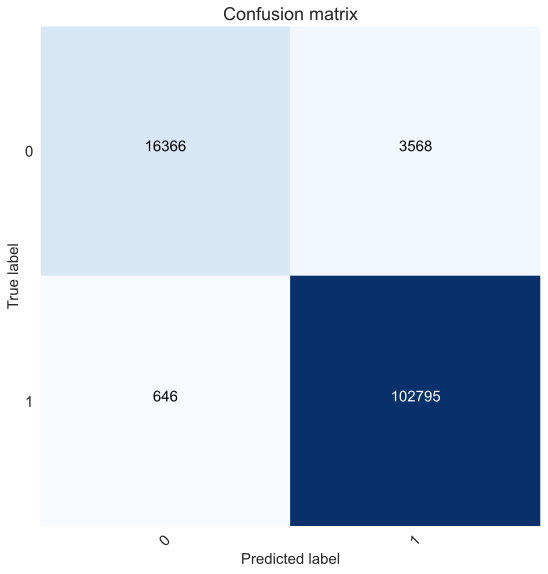

In [49]:
import itertools
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, log_reg.predict(X_test_tfidf))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.show()

Даже с параметрами по умолчанию получился уже достаточно хороший результат

Попробуем обучить CatBoost и RandomForest на выделенных ранее признаках и посмотреть, что будет

In [50]:
df_1.drop(['url', 'tfldextract'], axis=1, inplace=True)

In [51]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(df_1.drop(['label'], axis=1), df_1['label'], test_size=0.3, random_state=42, stratify=df_1['label'])

In [55]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(random_state=17, n_splits=3, shuffle=True)

In [56]:
from sklearn.ensemble import RandomForestClassifier

param_grid ={'n_estimators': [i for i in range(5, 20, 3)],
             'criterion': ['entropy'],
             'max_depth': [i for i in range(2, 11, 3)]
             
}

clf = RandomForestClassifier(class_weight='balanced')
clf_cv = GridSearchCV(clf, param_grid, cv=skf, scoring='recall', n_jobs=-1)
clf_cv.fit(X_train_f, y_train_f)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [2, 5, 8],
                         'n_estimators': [5, 8, 11, 14, 17]},
             scoring='recall')

In [61]:
roc_auc_score(y_test_f, clf_cv.predict_proba(X_test_f)[:, 0])

0.361783300840027

Confusion matrix, without normalization
[[ 5750 14184]
 [ 6779 96662]]


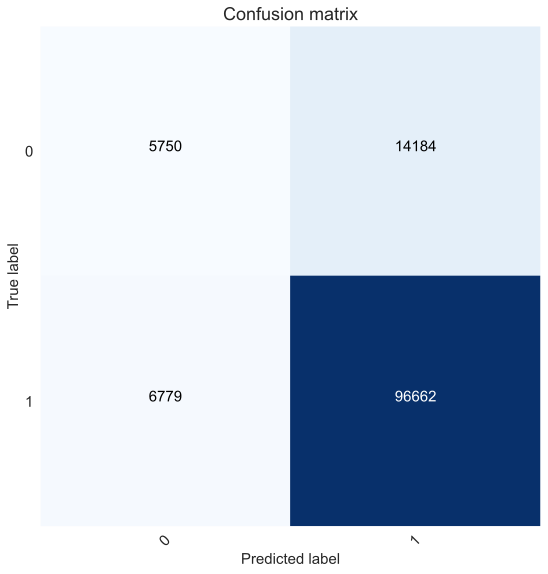

In [62]:
cnf_matrix = confusion_matrix(y_test_f, clf_cv.predict(X_test_f))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.show()

In [63]:
print(classification_report(y_test_f, clf_cv.predict(X_test_f)))

              precision    recall  f1-score   support

           0       0.46      0.29      0.35     19934
           1       0.87      0.93      0.90    103441

    accuracy                           0.83    123375
   macro avg       0.67      0.61      0.63    123375
weighted avg       0.81      0.83      0.81    123375



In [64]:
from catboost import CatBoostClassifier

clf_cb = CatBoostClassifier()
params = {'iterations': [i for i in range(100, 150)],
          'learning_rate': [0.1],
          'depth': [3],
          'loss_function': ['Logloss']
         }

clf_grid = GridSearchCV(clf_cb, params, scoring='f1', n_jobs=-1)

clf_grid.fit(X_train_f, y_train_f)


0:	learn: 0.6449231	total: 171ms	remaining: 25.3s
1:	learn: 0.6056310	total: 188ms	remaining: 13.8s
2:	learn: 0.5732298	total: 206ms	remaining: 10s
3:	learn: 0.5464780	total: 223ms	remaining: 8.1s
4:	learn: 0.5238891	total: 241ms	remaining: 6.95s
5:	learn: 0.5050844	total: 259ms	remaining: 6.16s
6:	learn: 0.4887591	total: 275ms	remaining: 5.58s
7:	learn: 0.4751081	total: 292ms	remaining: 5.14s
8:	learn: 0.4637837	total: 309ms	remaining: 4.81s
9:	learn: 0.4537555	total: 325ms	remaining: 4.51s
10:	learn: 0.4455009	total: 342ms	remaining: 4.29s
11:	learn: 0.4382113	total: 358ms	remaining: 4.08s
12:	learn: 0.4320928	total: 376ms	remaining: 3.93s
13:	learn: 0.4268479	total: 392ms	remaining: 3.78s
14:	learn: 0.4219046	total: 409ms	remaining: 3.66s
15:	learn: 0.4175434	total: 427ms	remaining: 3.55s
16:	learn: 0.4142242	total: 444ms	remaining: 3.44s
17:	learn: 0.4113442	total: 461ms	remaining: 3.35s
18:	learn: 0.4089343	total: 478ms	remaining: 3.27s
19:	learn: 0.4068186	total: 495ms	remaining:

KeyError: 0

In [65]:
print(f'Лучшее качество - {roc_auc_score(y_test_f, clf_grid.best_estimator_.predict_proba(X_test_f)[:,1])}')
print(f'Параметры: {clf_grid.best_params_}')

Лучшее качество - 0.7269561494909788
Параметры: {'depth': 3, 'iterations': 149, 'learning_rate': 0.1, 'loss_function': 'Logloss'}


Видно, что на выделенных признаках у нас не получается такой точности, как с использованием tfidf

Попробуем настроить параметры tfidf, учитывать последовательность в url и использовать GridSearch для логистической регрессии

In [66]:
url_df = pd.DataFrame()


url_df['extract'] = df['url'].apply(tldextract.extract)
url_df['urlparse'] = df['url'].apply(urlparse)

# достаем 4 текстовых признака
url_df['hostname'] = url_df['urlparse'].apply(lambda x: x.path.split('/')[0])
url_df['suffix'] = url_df['extract'].apply(lambda x: x.suffix.replace('.', ' '))
url_df['path'] = url_df['urlparse'].apply(lambda x: ''.join([s + ' ' for s in x.path.split('/')[1:]]).strip())
url_df['domain'] = url_df['extract'].apply(lambda x: x.domain)

In [67]:
url_df.drop(['extract', 'urlparse'], axis=1, inplace=True)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(url_df, df_1['label'], test_size=0.3, random_state=42, stratify=df_1['label'])

In [69]:
def to_tfidf(X_train1, X_test1, n, max_feat):    
    tfidf = TfidfVectorizer(ngram_range=(1, n), max_features=max_feat)
    train_1 = tfidf.fit_transform(X_train1['hostname'])
    test_1 = tfidf.transform(X_test1['hostname'])
    train_2 = tfidf.fit_transform(X_train1['suffix'])
    test_2 = tfidf.transform(X_test1['suffix'])
    train_3 = tfidf.fit_transform(X_train1['path'])
    test_3 = tfidf.transform(X_test1['path'])
    train_4 = tfidf.fit_transform(X_train1['domain'])
    test_4 = tfidf.transform(X_test1['domain'])
    X_train_sparse_cv = csr_matrix(hstack([train_1, train_2, train_3, train_4]))
    X_test_sparse_cv = csr_matrix(hstack([test_1, test_2, test_3, test_4]))
    return X_train_sparse_cv, X_test_sparse_cv

X_train_tfidf, X_test_tfidf = to_tfidf(X_train, X_test, 1, 50000)

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
log_reg = LogisticRegression(random_state=42)

log_reg_cv = GridSearchCV(log_reg, param_grid, scoring='roc_auc')
log_reg_cv.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [74]:
def metrics(X_test_m, y_test_m, model):

    print(roc_auc_score(y_test_m, model.predict_proba(X_test_m)[:, 1]))

    cnf_matrix = confusion_matrix(y_test_m, model.predict(X_test_m))
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title='Confusion matrix')
    plt.show()

    print(classification_report(y_test_m, model.predict(X_test_m)))

0.9916249093048524
Confusion matrix, without normalization
[[ 17460   2474]
 [   572 102869]]


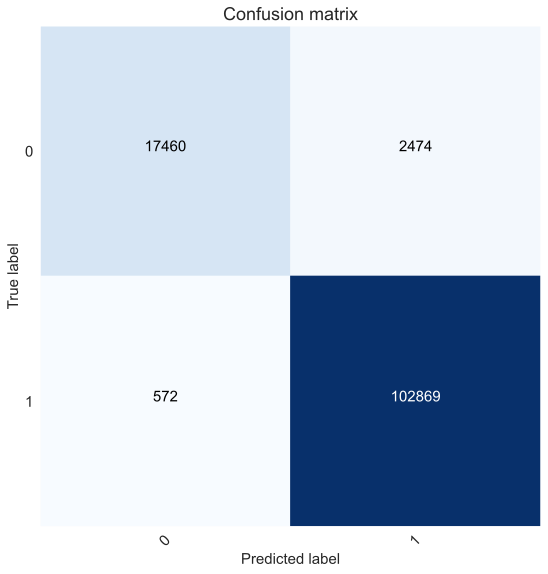

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     19934
           1       0.98      0.99      0.99    103441

    accuracy                           0.98    123375
   macro avg       0.97      0.94      0.95    123375
weighted avg       0.98      0.98      0.97    123375



In [75]:
metrics(X_test_tfidf, y_test, log_reg_cv)

In [76]:
log_reg_cv.best_params_

{'C': 10}

In [79]:
score = []
for i in range(1, 3):
    for k in range(50000, 100001, 10000):
        X_train_tfidf, X_test_tfidf = to_tfidf(X_train, X_test, i, k)
        log_reg = LogisticRegression(C=10, random_state=42)
        log_reg.fit(X_train_tfidf, y_train)
        score.append(recall_score(y_test, log_reg.predict(X_test_tfidf), pos_label=0))

In [80]:
score

[0.8758904384468746,
 0.8750877897060299,
 0.8756396107153607,
 0.8812079863549714,
 0.882311628373633,
 0.8790007023176483,
 0.8656566670011037,
 0.8706230560850807,
 0.8694692485201164,
 0.8697200762516304,
 0.8716765325574396,
 0.8732818300391292]